In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.utils import get_cc_mat, get_dataset, non_stratify_split
from src.ml2rules import TreeRuler, ml2tree
from src.machinelearning import (
    train_decisiontree,
    train_skoperules,
    evaluate_sklearn,
    ANNClassifier,
    train_ann,
    evaluate_ann,
    get_predictions
)

In [34]:
def plot_cc_ranges(df: pd.DataFrame) -> None:
    # Change plot style
    plt.style.use("ggplot")
    # Calculate the 1st and 3rd quartiles of df values
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    # Plot the mean of df values
    plt.figure(figsize=(10, 3))
    plt.barh(df.columns[::-1], df.mean()[::-1])
    plt.axvline(x=0, color="black", linestyle="-")
    plt.plot(q1, df.columns, "|", color="black", label="Q1", alpha=1)
    plt.plot(q3, df.columns, "|", color="black", label="Q3", alpha=1)
    for i, enzyme in enumerate(df.columns):
        plt.plot([q1[i], q3[i]], [enzyme, enzyme], color="black")
    plt.title("CC_XTR")
    plt.grid()
    plt.show()
    
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )


### Data loading

***Dataset shape: (200000, 259)

Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


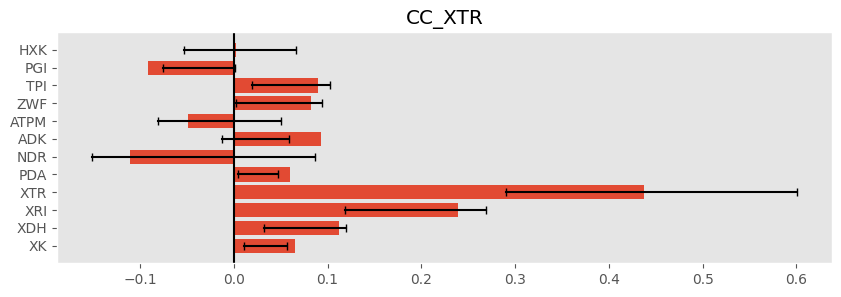

In [10]:
df = get_dataset(
    labels_file="../data/class_vector_train_ref.mat",
    params_file="../data/training_set_ref.mat",
    names_file="../data/paremeterNames.mat",
)

print(f"***Dataset shape: {df.shape}\n")

# Load FCC data
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat("../data/ccXTR_ref.mat")

plot_cc_ranges(commonConCoeff)

In [25]:
# Create dataset for HXK enzyme; label 1 if CC < 0, 0 otherwise
idx_HXK = commonConCoeff[commonConCoeff["HXK"] < 0].index

df_HXK = df.drop("label", axis=1)
df_HXK["label"] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK["label"].value_counts(normalize=True).round(4)
df = df_HXK.copy()

# Create a dataframe with value_counts both percentage and absolute
display(
    pd.DataFrame(
    data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
    index=["percentage", "absolute"]    
).T
)

del df_HXK

,percentage,absolute
0,0.5287,105746.0
1,0.4713,94254.0


### Train - Test data split

In [35]:
# Split data
X_train, X_test, y_train, y_test = non_stratify_split(
    data=df, train_size=10000, target="label"
)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print('Training set value counts:')
get_value_counts(train_df)

print('Test set value counts:')
get_value_counts(test_df)

Traininig set shape: (10000, 258)
Test set shape: (190000, 258)
Training set value counts:


,percentage,absolute
0,0.65,6500.0
1,0.35,3500.0


Test set value counts:


,percentage,absolute
0,0.5223,99246.0
1,0.4777,90754.0


### Feature Selection

### Machine Learning

##### Decision Tree - iSHRUNCK

In [ ]:
cart_model = train_decisiontree(X_train, y_train, scoring='roc_auc', n_trials=200)

In [39]:
cart_model

DecisionTreeClassifier(max_depth=5, min_samples_leaf=11, min_samples_split=22)

In [45]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.6896
Precision: 0.6315
Recall: 0.2717
F1 score: 0.3799
ROC AUC score: 0.5932
Matthews correlation coefficient: 0.2485

*** Evaluation on test set:
Accuracy: 0.5714
Precision: 0.6513
Recall: 0.2211
F1 score: 0.3301
ROC AUC score: 0.5564
Matthews correlation coefficient: 0.1529


In [61]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
ruler.rules

['if (ASN@pi_m > 0.679) and (XRI@nadh_c <= 0.633) and (ASN@atp_m <= 0.573) and (FUM@fum_m <= 0.822) and (NDH@q_m <= 0.938) then class: 1 (proba: 66.42%) | based on 667 samples',
 'if (ASN@pi_m > 0.679) and (XRI@nadh_c <= 0.633) and (ASN@atp_m > 0.573) and (XDH@xlt_c <= 0.757) and (XRI@nadh_c <= 0.196) then class: 1 (proba: 61.62%) | based on 198 samples',
 'if (ASN@pi_m <= 0.679) and (XRI@nadh_c > 0.526) and (XRI@nad_c > 0.559) and (TPI@t3p_c > 0.689) and (PFK@fbp_c <= 0.506) then class: 1 (proba: 50.51%) | based on 196 samples',
 'if (ASN@pi_m > 0.679) and (XRI@nadh_c <= 0.633) and (ASN@atp_m <= 0.573) and (FUM@fum_m > 0.822) and (ZWF@nadph_c > 0.193) then class: 1 (proba: 54.89%) | based on 133 samples',
 'if (ASN@pi_m <= 0.679) and (XRI@nadh_c <= 0.526) and (GND1@6pgl_c > 0.942) and (CAT@car_c > 0.092) and (TKL2@f6p_c <= 0.62) then class: 1 (proba: 72.18%) | based on 133 samples',
 'if (ASN@pi_m > 0.679) and (XRI@nadh_c > 0.633) and (GND1@6pgl_c > 0.82) and (BIO@3pg_c > 0.367) and (

In [76]:
_ = test_df[test_df['ASN@pi_m'] > 0.679]
_ = _[_['XRI@nadh_c'] <= 0.633]
_ = _[_['ASN@atp_m'] <= 0.573]
_ = _[_['FUM@fum_m'] <= 0.822]
_ = _[_['NDH@q_m'] <= 0.938]

get_value_counts(_)

,percentage,absolute
1,0.7068,10415.0
0,0.2932,4320.0


##### Skope - Rules

In [ ]:
skope_rules_clf = train_skoperules(X_train, y_train, scoring='matthews_corrcoef', n_iter=50)

In [52]:
skope_rules_clf

SkopeRules(feature_names=['BIO@atp_c', 'BIO@pyr_c', 'BIO@nad_c', 'BIO@g6p_c',
                          'BIO@oaa_c', 'BIO@f6p_c', 'BIO@nadph_c', 'BIO@nh4_c',
                          'BIO@o2_c', 'BIO@r5p_c', 'BIO@3pg_c', 'BIO@akg_m',
                          'BIO@accoa_c', 'BIO@pep_c', 'BIO@e4p_c', 'BIO@so4_c',
                          'HXT@glc_c', 'HXK@atp_c', 'HXK@glc_c', 'HXK@adp_c',
                          'HXK@g6p_c', 'PGI@g6p_c', 'PGI@f6p_c', 'PFK@f6p_c',
                          'PFK@atp_c', 'PFK@fbp_c', 'PFK@adp_c', 'FBA@fbp_c',
                          'FBA@t3p_c', 'FBA@dhap_c', ...],
           max_depth_duplication=1, max_samples=0.5, n_estimators=50, n_jobs=-1,
           precision_min=0.15, random_state=42, recall_min=0.2)

In [78]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_:
    print(i)

*** Number of rules 2
('ASN@pi_m <= 0.8330636918544769 and XRI@nadh_c <= 0.5875035524368286 and TPI@t3p_c > 0.21913046389818192', (0.39123867069486407, 0.4455275229357798, 2))
('ASN@pi_m > 0.7063775658607483 and ASN@atp_m <= 0.943718671798706 and XRI@xlt_c <= 0.8738300800323486', (0.5393586005830904, 0.31732418524871353, 2))


In [79]:
_ = test_df[test_df['ASN@pi_m'] >= 0.7064]
_ = _[_['ASN@atp_m'] <= 0.9437]
_ = _[_['XRI@xlt_c'] <= 0.8738]

get_value_counts(_)

,percentage,absolute
1,0.6265,25035.0
0,0.3735,14922.0


##### Neural Network

In [64]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ANNClassifier(input_dim=X_train.shape[1], hidden_dim=2048,
                    output_dim=1, hidden_layers=4).to(device)
net = train_ann(net, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048)

Epoch 0, Loss: 0.685042
Epoch 10, Loss: 0.555546
Epoch 20, Loss: 0.510194
Epoch 30, Loss: 0.435001
Epoch 40, Loss: 0.211451
Epoch 50, Loss: 0.174435
Epoch 60, Loss: 0.007603
Epoch 70, Loss: 0.000099
Epoch 80, Loss: 0.000026
Epoch 90, Loss: 0.000017
Epoch 100, Loss: 0.000011
Epoch 110, Loss: 0.000008
Epoch 120, Loss: 0.000006
Epoch 130, Loss: 0.000004
Epoch 140, Loss: 0.000003
Epoch 150, Loss: 0.000003
Epoch 160, Loss: 0.000002
Epoch 170, Loss: 0.000002
Epoch 180, Loss: 0.000002
Epoch 190, Loss: 0.000002
Epoch 200, Loss: 0.000001
Epoch 210, Loss: 0.000001
Epoch 220, Loss: 0.000001
Epoch 230, Loss: 0.000001
Epoch 240, Loss: 0.000001
Epoch 250, Loss: 0.000001
Epoch 260, Loss: 0.000001
Epoch 270, Loss: 0.000001
Epoch 280, Loss: 0.000001
Epoch 290, Loss: 0.000001
Early stopping on epoch 299


In [65]:
# Evaluate model
evaluate_ann(net, X_test, y_test)

Accuracy: 0.6117
Precision: 0.6330
Recall: 0.4452
F1: 0.5227
MCC: 0.2212


In [ ]:
ann_preds = get_predictions(net, X_train)
ann2tree = ml2tree(X_train, ann_preds, n_trials=200)

In [69]:
ann2tree

DecisionTreeClassifier(max_depth=3, min_samples_leaf=13, min_samples_split=18)

In [70]:
evaluate_sklearn(ann2tree, X_test, y_test)

Accuracy: 0.5729
Precision: 0.6748
Recall: 0.2042
F1 score: 0.3135
ROC AUC score: 0.5571
Matthews correlation coefficient: 0.1622


In [71]:
ruler = TreeRuler(df=train_df, tree_clf=ann2tree, target="label")
ruler.get_rules()
ruler.rules

['if (ASN@pi_m > 0.679) and (XRI@nadh_c <= 0.633) and (ASN@atp_m <= 0.573) then class: 1 (proba: 60.97%) | based on 889 samples',
 'if (ASN@pi_m <= 0.679) and (XRI@nadh_c <= 0.526) and (GND1@6pgl_c > 0.942) then class: 1 (proba: 57.71%) | based on 227 samples',
 'if (ASN@pi_m > 0.679) and (XRI@nadh_c > 0.633) and (GND1@6pgl_c > 0.82) then class: 1 (proba: 56.28%) | based on 215 samples']

In [74]:
_ = test_df[test_df['ASN@pi_m'] > 0.679]
_ = _[_['XRI@nadh_c'] <= 0.633]
_ = _[_['ASN@atp_m'] <= 0.573]

get_value_counts(_)

,percentage,absolute
1,0.7007,13445.0
0,0.2993,5742.0


### Exlainable Machine Learning